# Experiment

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## 1. Data

### 1.1 Load Data

In [2]:
with open('../data/x_train.npy', 'rb') as f:
    X_train = np.load(f)

with open('../data/y_train.npy', 'rb') as f:
    y_train = np.load(f)

with open('../data/x_test.npy', 'rb') as f:
    X_test = np.load(f)

with open('../data/y_test.npy', 'rb') as f:
    y_test = np.load(f)

### 1.2 Create Generators

In [3]:
class KerasBatchGenerator(object):

    def __init__(self, x_data, y_data, batch_size, num_steps, num_features, num_classes = 8):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_features = num_features
        self.num_classes = num_classes
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        
    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps, self.num_features))
        y = np.zeros((self.batch_size, self.num_classes))
        while True:
            for i in range(self.batch_size):
                if self.current_idx >= len(self.x_data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :, :] = self.x_data[self.current_idx,:,:]
                temp_y = self.y_data[self.current_idx]
                # convert all of temp_y into a one hot representation
                y[i, :] = to_categorical(temp_y, num_classes=self.num_classes)
                self.current_idx += 1
            yield x, y

In [4]:
batch_size = 1024
num_steps  = 22
num_features = 31
hidden_size = 64
num_classes = 8

train_data_generator = KerasBatchGenerator(X_train, y_train, batch_size, num_steps, num_features)
valid_data_generator = KerasBatchGenerator(X_test, y_test, batch_size, num_steps, num_features)

## 2. Model

### 2.1 Build

In [5]:
model = Sequential()
model.add(LSTM(num_features, return_sequences=True, input_shape=(num_steps, num_features)))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 31)            7812      
_________________________________________________________________
lstm_1 (LSTM)                (None, 22, 64)            24576     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
Total params: 65,932
Trainable params: 65,932
Non-trainable params: 0
____________________________________________________

### 2.2 Train

In [8]:
data_path = '../models'
checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', 
                               save_best_only=True, monitor='val_loss', mode='min', 
                               verbose=1)

In [19]:
num_epochs = 80
history = model.fit_generator(train_data_generator.generate(), len(X_train)//(batch_size), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(X_test)//(batch_size), callbacks=[checkpointer])

Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 0.9670 - categorical_accuracy: 0.6747
Epoch 00001: val_loss did not improve from 0.86492
21/21 [==============================] - 5s 222ms/step - loss: 0.9670 - categorical_accuracy: 0.6747 - val_loss: 1.0195 - val_categorical_accuracy: 0.6479
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.1709 - categorical_accuracy: 0.5924
Epoch 00002: val_loss did not improve from 0.86492
21/21 [==============================] - 5s 218ms/step - loss: 1.1709 - categorical_accuracy: 0.5924 - val_loss: 1.1123 - val_categorical_accuracy: 0.6158
Epoch 3/80
21/21 [==============================] - ETA: 0s - loss: 1.1006 - categorical_accuracy: 0.6238
Epoch 00003: val_loss did not improve from 0.86492
21/21 [==============================] - 5s 225ms/step - loss: 1.1006 - categorical_accuracy: 0.6238 - val_loss: 1.0794 - val_categorical_accuracy: 0.6250
Epoch 4/80
21/21 [==============================] - ETA: 0s - lo

Epoch 27/80
21/21 [==============================] - ETA: 0s - loss: 1.0445 - categorical_accuracy: 0.6376
Epoch 00027: val_loss did not improve from 0.66278
21/21 [==============================] - 5s 230ms/step - loss: 1.0445 - categorical_accuracy: 0.6376 - val_loss: 1.0285 - val_categorical_accuracy: 0.6393
Epoch 28/80
21/21 [==============================] - ETA: 0s - loss: 1.0303 - categorical_accuracy: 0.6421
Epoch 00028: val_loss did not improve from 0.66278
21/21 [==============================] - 5s 231ms/step - loss: 1.0303 - categorical_accuracy: 0.6421 - val_loss: 1.0103 - val_categorical_accuracy: 0.6447
Epoch 29/80
21/21 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.6512
Epoch 00029: val_loss did not improve from 0.66278
21/21 [==============================] - 5s 248ms/step - loss: 1.0031 - categorical_accuracy: 0.6512 - val_loss: 0.9746 - val_categorical_accuracy: 0.6584
Epoch 30/80
21/21 [==============================] - ETA: 0s 

Epoch 53/80
21/21 [==============================] - ETA: 0s - loss: 1.0660 - categorical_accuracy: 0.6322
Epoch 00053: val_loss did not improve from 0.64614
21/21 [==============================] - 5s 234ms/step - loss: 1.0660 - categorical_accuracy: 0.6322 - val_loss: 1.0413 - val_categorical_accuracy: 0.6348
Epoch 54/80
21/21 [==============================] - ETA: 0s - loss: 1.0341 - categorical_accuracy: 0.6374
Epoch 00054: val_loss did not improve from 0.64614
21/21 [==============================] - 5s 257ms/step - loss: 1.0341 - categorical_accuracy: 0.6374 - val_loss: 1.0203 - val_categorical_accuracy: 0.6391
Epoch 55/80
21/21 [==============================] - ETA: 0s - loss: 1.0178 - categorical_accuracy: 0.6430
Epoch 00055: val_loss did not improve from 0.64614
21/21 [==============================] - 5s 250ms/step - loss: 1.0178 - categorical_accuracy: 0.6430 - val_loss: 0.9896 - val_categorical_accuracy: 0.6502
Epoch 56/80
21/21 [==============================] - ETA: 0s 

21/21 [==============================] - ETA: 0s - loss: 1.0186 - categorical_accuracy: 0.6469
Epoch 00079: val_loss did not improve from 0.64614
21/21 [==============================] - 5s 225ms/step - loss: 1.0186 - categorical_accuracy: 0.6469 - val_loss: 1.0215 - val_categorical_accuracy: 0.6393
Epoch 80/80
21/21 [==============================] - ETA: 0s - loss: 0.9941 - categorical_accuracy: 0.6586
Epoch 00080: val_loss did not improve from 0.64614
21/21 [==============================] - 5s 224ms/step - loss: 0.9941 - categorical_accuracy: 0.6586 - val_loss: 0.9751 - val_categorical_accuracy: 0.6676


### 2.3 Results

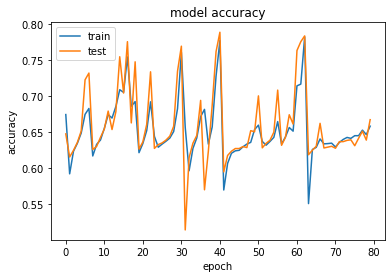

In [20]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

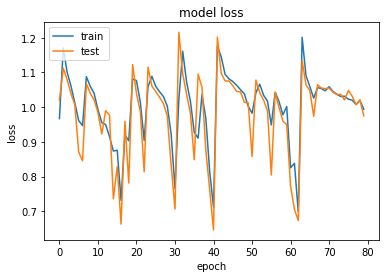

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Interpretation

In [23]:
#Classification Report
model.load_weights(data_path + '/model-41.hdf5')
y_pred = model.predict_classes(X_test)
print('Classification Report')
target_names = ['Agent Call Back', 'Do Not Call', 'No Sale', 'Non Workable', 
                'Sale', 'Still Workable', 'System disposition', 'Transfer Call']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
                    precision    recall  f1-score   support

   Agent Call Back       0.00      0.00      0.00       109
       Do Not Call       0.00      0.00      0.00        40
           No Sale       0.74      0.98      0.84      2040
      Non Workable       0.76      0.64      0.70       663
              Sale       0.87      0.37      0.52       217
    Still Workable       0.85      0.96      0.90      1940
System disposition       0.00      0.00      0.00        34
     Transfer Call       0.00      0.00      0.00       508

          accuracy                           0.79      5551
         macro avg       0.40      0.37      0.37      5551
      weighted avg       0.69      0.79      0.73      5551

